### Brute Force Simulation of 1d transverse field Ising model.


The 1d transverse field Ising model features a chain of spins (qubits) with a
magnetic field orthogonal to the chain. The qubits only interact with the nearest
neighbours.
The Hamiltonian is of the form:

\begin{equation}
H = J \sum_{i=1}^{N-1} \sigma_i^z \sigma_{i+1}^z + h \sum_{i=1}^{N} \sigma_i^x
\end{equation}

for open boundary conditions (first and last lattice site only have one neighbour).
The $\sigma_i$ are Pauli matrices, N is the number of qubits and $J$ and $h$ are coupling
constants describing the coupling strength of the
nearest neighbour interaction and the strength of the magnetic field respectively.
If we assume periodic boundary conditions the last qubit interacts with the first qubit.
The Hamiltonian takes the form:

\begin{equation}
H = J \sum_{i=1}^{N} \sigma_i^z \sigma_{i+1}^z + h \sum_{i=1}^{N} \sigma_i^x
\end{equation}

where we assume $\sigma^z_{N+1} = \sigma^z_1$.

We simulate the 1d transverse field Ising model for different numbers of qubits (Spins) $N$
and for different ratios $\frac{h}{J}$ where we set $J=-1$ (ferromagnetic case). In the
following we calculate the numerical values for the oberservables energy-gap,
two-point-correlation, correlation length and entanglement entropy.
To calculate all of these we need the ground state and the first few eigenvalues of our
Hamiltonian. Thus, we calculate them first and store them because this is the most
computationally expensive part.

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
sys.path.append('..\src')
from tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from bf_quantum_state import BFQuantumState

In [2]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs_open: str = 'data\Diagonal_hamiltonian\eigenvalues_open_first_three_dict.npy'
save_direc_groundstate_open: str = 'data\Diagonal_hamiltonian\groundstate_open_dict.npy'
save_direc_eigs_periodic: str = 'data\Diagonal_hamiltonian\eigenvalues_periodic_first_three_dict.npy'
save_direc_groundstate_periodic: str = 'data\Diagonal_hamiltonian\groundstate_perioidc_dict.npy'


In [16]:
# calculate for open boundary conditions

qubit_numbers = np.array([10, 12, 14])
energy_eig_vals_dict: dict = {}
ground_state_dict: dict = {}
for i in range(0, np.size(qubit_numbers)):
    for j in range(0, np.size(ratios_h_j)):
        energy_eig_vals, eigvecs = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1, 'open').diagonalize(3, True)
        ground_state = pt.tensor(eigvecs[:, 0])
        key = str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])
        energy_eig_vals_dict[key] = energy_eig_vals
        ground_state_dict[key] = ground_state
np.save(save_direc_eigs_open, energy_eig_vals_dict)
np.save(save_direc_groundstate_open, ground_state_dict)

In [17]:
#calculate for periodic boundary conditions

qubit_numbers = np.array([10, 12, 14])
energy_eig_vals_dict: dict = {}
ground_state_dict: dict = {}
for i in range(0, np.size(qubit_numbers)):
    for j in range(0, np.size(ratios_h_j)):
        energy_eig_vals, eigvecs = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1, 'periodic').diagonalize(3, True)
        ground_state = pt.tensor(eigvecs[:, 0])
        key = str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])
        energy_eig_vals_dict[key] = energy_eig_vals
        ground_state_dict[key] = ground_state
np.save(save_direc_eigs_periodic, energy_eig_vals_dict)
np.save(save_direc_groundstate_periodic, ground_state_dict)


### ground state energy per qubit
We would like to calculate the energy $E_0$ of the ground state divided by the number of
qubits $N$. We then compare it with the value predicted by theory for periodic boundary
conditions. The ground state energy is given by

\begin{equation}
E_0 = - \sum_{k>0} \epsilon_k
\end{equation} (periodic boundary conditions)

where

\begin{equation}
\epsilon_k = 2J \sqrt{(\cos{k} - |\frac{h}{J}|)^2 + \sin^2{k}}
\end{equation}.

$k$ can take the values:

\begin{equation}
k \in (\frac{(2n-1)\pi}{N};   n=1, ..., N/2 )
\end{equation}

$N$ is the number of qubits.

We start with plotting the ground state energy for periodic boundary conditions
 using our exact simulation for the example of 12 and 14 qubits.

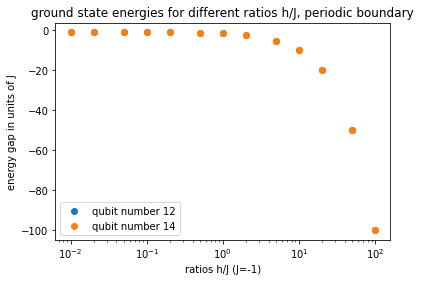

In [3]:
def plot_ground_state_energy_periodic():
    qubit_num = np.array([12, 14])
    energy_dict = np.load(save_direc_eigs_periodic, allow_pickle='TRUE')
    energy_dict = energy_dict.item()
    for i in range(0, np.size(qubit_num)):
        energy = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            energy[j] = energy_dict[str(qubit_num[i]) + ' ' + str(ratios_h_j[j])][0]
        energy_per_qubit = energy / qubit_num[i]
        plt.scatter(ratios_h_j, energy_per_qubit, label='qubit number ' + str(qubit_num[i]))
    plt.xscale('log')
    plt.title('ground state energies for different ratios h/J, periodic boundary')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('energy gap in units of J')
    plt.legend()
    plot_save_direc = 'plots\Ground_state_energy\Ground_state_energies_per_qubit_periodic'
    plt.savefig(plot_save_direc)
plot_ground_state_energy_periodic()

Now we compare this with the theoretical prediction and plot the difference
$E_{simulated} - E_{theo}$.


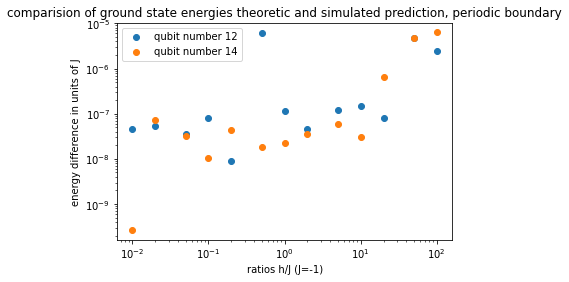

In [4]:
def plot_comparison_ground_state_energy_theo_and_simulated():
    qubit_num = np.array([12, 14])
    energy_dict = np.load(save_direc_eigs_periodic, allow_pickle='TRUE')
    energy_dict = energy_dict.item()
    for i in range(0, np.size(qubit_num)):
        energy_sim = np.zeros(np.size(ratios_h_j))
        energy_theo = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            energy_sim[j] = energy_dict[str(qubit_num[i]) + ' ' + str(ratios_h_j[j])][0]
            energy_theo[j] = TfimHamiltonianOpenFermion(qubit_num[i], ratios_h_j[j], 1, 'periodic').ground_state_energy_theo()
        energy_diff_per_qubit = np.abs(np.abs(energy_sim) - np.abs(energy_theo)) / qubit_num[i]
        plt.scatter(ratios_h_j, energy_diff_per_qubit, label='qubit number ' + str(qubit_num[i]))
    plt.yscale('log')
    plt.xscale('log')
    plt.title('comparision of ground state energies theoretic and simulated prediction, periodic boundary')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('energy difference in units of J')
    plt.legend()
    plot_save_direc = 'plots\Ground_state_energy\comparison_theo_and_simulated'
    plt.savefig(plot_save_direc)
plot_comparison_ground_state_energy_theo_and_simulated()


This shows that the theoretical and our simulated model agree in their precdictions since
all deviations are very small and due to random numerical rounding issues.


### Energy gap estimation
We would like to calculate the energy gap $E_{gap}$ between the ground state energy
 $E_{ground}$ and the
first excited state $E_{excited}$.

For the case $J>h$ the coupling between the qubits is
the dominant interaction and not the outer magnetic field. Thus, when measuring in the
z-basis the spins are all aligned in one direction since this is the lowest energy state
in the ferromagnetic case ($J<0$) that we consider here. The two configurations where all
spins are pointing and where all spins are pointing down are equivalent. Thus, the ground
state is two-fold-degenerate and the first two energy eigenvalues are the same. Therefore,
the energy gap is given by $E_{gap} = E_2 - E_0$ where $E_0$ is the 0-th energy eigenvalue and
$E_2$ is the second.

$J = h$ is the point of the phase transition where the degenerate state starts to
split up. The energy gap is still given by $E_{gap} = E_2 - E_0$.


For the case $J < h $ the magnetic field is dominant and the ground state is not
two-fold-degenerate anymore. Hence, the energy gap is given by $E_{gap} = E_1 - E_0$.

In our simulation we obtain the energy gap by exactly diagonalizing the Hamiltonian
from which we get the energy eigenvalues. First we assume open boundary conditions.


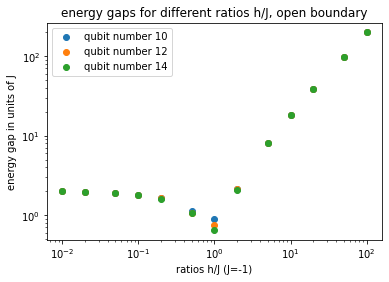

In [6]:
def plot_energy_gap_open_boundary():
    qubit_numbers = ([10, 12, 14])
    energies_dict = np.load(save_direc_eigs_open, allow_pickle='TRUE')
    energies_dict = energies_dict.item()
    for i in range(0, np.size(qubit_numbers)):
        energy_gaps = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            key = str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])
            energy_gaps[j] = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1, 'open').energygap(energies_dict[key])
        plt.scatter(ratios_h_j, energy_gaps, label='qubit number ' + str(qubit_numbers[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('energy gaps for different ratios h/J, open boundary')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('energy gap in units of J')
    plt.legend()
    plot_save_direc = 'plots\energy_gap_brute_force\energy_gaps_open_boundary '
    plt.savefig(plot_save_direc)
plot_energy_gap_open_boundary()

Now we assume periodic boundary conditions and do the same.

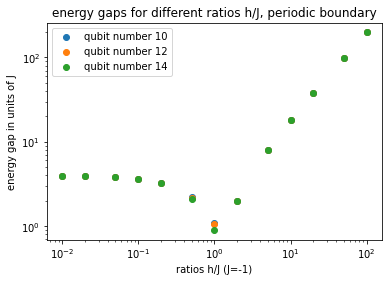

In [7]:
def plot_energy_gap_periodic_boundary():
    qubit_numbers = ([10, 12, 14])
    energies_dict = np.load(save_direc_eigs_periodic, allow_pickle='TRUE')
    energies_dict = energies_dict.item()
    for i in range(0, np.size(qubit_numbers)):
        energy_gaps = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            key = str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])
            energy_gaps[j] = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1, 'periodic').energygap(energies_dict[key])
        plt.scatter(ratios_h_j, energy_gaps, label='qubit number ' + str(qubit_numbers[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('energy gaps for different ratios h/J, periodic boundary')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('energy gap in units of J')
    plt.legend()
    plot_save_direc = 'plots\energy_gap_brute_force\energy_gaps_periodic_boundary '
    plt.savefig(plot_save_direc)
plot_energy_gap_periodic_boundary()

Now we would like to see how $E_{gap}$ depends on the choice of the boundary condition.
To see this we plot the difference of the energy gaps for both cases $|E_{gap-periodic} -
E_{gap-open}|$.

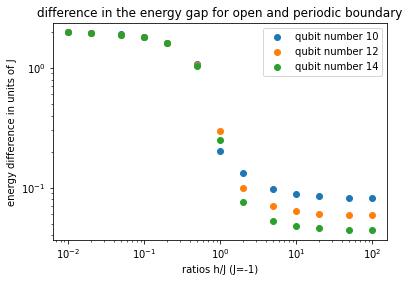

In [8]:
def plot_energy_gap_difference_open_periodic():
    qubit_numbers = ([10, 12, 14])
    energies_dict_periodic = np.load(save_direc_eigs_periodic, allow_pickle='TRUE')
    energies_dict_periodic = energies_dict_periodic.item()
    energies_dict_open = np.load(save_direc_eigs_open, allow_pickle='TRUE')
    energies_dict_open = energies_dict_open.item()
    for i in range(0, np.size(qubit_numbers)):
        energy_difference = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            energy_gap_periodic = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1,
                                                             'periodic').energygap(energies_dict_periodic[str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])])
            energy_gap_open = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], 1,
                                                         'periodic').energygap(energies_dict_open[str(qubit_numbers[i]) + ' ' + str(ratios_h_j[j])])
            energy_difference[j] = np.abs(energy_gap_periodic - energy_gap_open)
        plt.scatter(ratios_h_j, energy_difference, label='qubit number ' + str(qubit_numbers[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('difference in the energy gap for open and periodic boundary')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('energy difference in units of J')
    plt.legend()
    plot_save_direc = 'plots\energy_gap_brute_force\energy_difference_open_periodic '
    plt.savefig(plot_save_direc)
plot_energy_gap_difference_open_periodic()

  From this we can see that the
 energy difference for $\frac{h}{J}<1$ is strongly influenced by the choice of the
 boundary condition whereas it is only weakly influenced for $\frac{h}{J} > 1$.
 This makes sense since only the first sum in the Hamiltonian
 $J \sum_{i=1}^{N-1} \sigma_i^z \sigma_{i+1}^z$ is influenced by whether we
 take periodic or open boundary conditions.

Now we would like to compare the energy gaps we calculated by exact diagonalization
with those predicted by theory. In the occupation number representation the possible
energies of the system are given by:

\begin{equation}
E_{n_k} = E_0 + \sum_k n_k \epsilon_k
\end{equation}

where $E_0$ is the ground state $n_k$ are the occupation numbers and $\epsilon_k$ are
the energy eigenvalues given by:

\begin{equation}
\epsilon_k = 2J \sqrt{(\cos{k} - | \frac{h}{J} |)^2 + \sin^2{k}}
\end{equation}.

$k$ can take the values:

\begin{equation}
k \in (\frac{(2n-1)\pi}{N};   n=1, ..., N/2 )
\end{equation}

$N$ is the number of qubits.

Comparison to be continued...


### Two point correlation of the ground state $\Psi_0$
The two point correlation between two qubits in the ground state $\Psi_0$ is defined by
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$. We calculate the two point
correlations for different distances $i$ and investigate how the correlation decays for
different ratios $\frac{h}{J}$. We choose open boundary conditions.
As an example we plot the two point correlation for 14 qubits and for different ratios of
$\frac{h}{J}$.


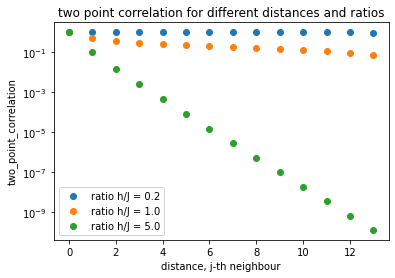

In [3]:
def plot_two_point_correlation():
    qubit_num = 14
    ratios = np.array([0.2, 1, 5])
    ground_state_open_dict = np.load(save_direc_groundstate_open, allow_pickle='TRUE')
    ground_state_open_dict = ground_state_open_dict.item()
    for i in range(0, np.size(ratios)):
        distance = np.arange(0, qubit_num, 1)
        correlations = np.zeros(qubit_num)
        ground_state = ground_state_open_dict[str(qubit_num) + ' ' + str(ratios[i])]
        for j in range(0, qubit_num):
            correlations[j] = BFQuantumState(qubit_num, ground_state).two_point_correlation(distance[j])
        plt.scatter(distance, np.abs(correlations), label='ratio h/J = ' + str(ratios[i]))
    plt.yscale('log')
    plt.title('two point correlation for different distances and ratios')
    plt.xlabel('distance, j-th neighbour')
    plt.ylabel('two_point_correlation')
    plt.legend()
    plot_save_direc = 'plots\Two_point_correlation_brute_force\correlation_for_ratio ' + str(ratios).replace('.',
                                                                                                             ',') + ' and qubit number ' + str(
        qubit_num)
    plt.savefig(plot_save_direc)

plot_two_point_correlation()

From this we can see that for $\frac{h}{J} > 1$ the correlation decays exponentially
while it decays polynomially for $\frac{h}{J} <= 1$. The reason for this is that for
$\frac{h}{J} > 1$ all spins are either pointing up or down as already discussed. Thus, the
system is mostly in the state $\Psi_0 = \frac{1}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$.
Therefore, we know the state of qubit $i$ with almost perfect certainty when we learn
about the state of qubit $0$ in the z-basis.

For $\frac{h}{J} < 1$ the qubits start to align with the magnetic field and converge
towards the state $\Psi_0 = |++ ... + \rangle$ where $|+ \rangle = \frac{1}{\sqrt{2}}
|0 \rangle + |1 \rangle$. Thus, when measuring the correlation in the z-basis the
system converges towards a perfectly uncorrelated state for $h \rightarrow \infty $.

For $\frac{h}{J} = 1$ we are still mostly in the perfectly correlated state
$\Psi_0 = \frac{1}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$ and hence
the correlation decays slower than exponentially.


### Correlation length
Now we would like to see after which distance the correlation
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$ has decayed by
$\frac{1}{e}$. We call this distance the correlation length.

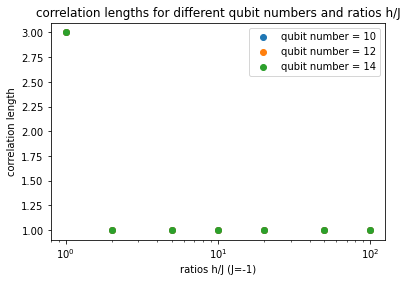

In [5]:
def plot_correlation_length():
    qubit_num = np.array([10, 12, 14])
    ground_state_open_dict = np.load(save_direc_groundstate_open, allow_pickle='TRUE')
    ground_state_open_dict = ground_state_open_dict.item()
    for i in range(0, np.size(qubit_num)):
        correlation_length = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            ground_state = ground_state_open_dict[str(qubit_num[i]) + ' ' + str(ratios_h_j[j])]
            correlation_length[j] = BFQuantumState(qubit_num[i], ground_state).correlation_length()
        plt.scatter(ratios_h_j, correlation_length, label='qubit number = ' + str(qubit_num[i]))
    plt.xscale('log')
    plt.title('correlation lengths for different qubit numbers and ratios h/J')
    plt.xlabel('ratios h/J (J=-1)')
    plt.ylabel('correlation length')
    plt.legend()
    plot_save_direc = 'plots\Correlation_length\correlation_lengths_for_qubit_numbers ' + str(qubit_num)
    plt.savefig(plot_save_direc)
plot_correlation_length()

Values for which the correlation does not decay to $\frac{1}{e}$ are not displayed at all.
We can see that only for $\frac{h}{J} >= 1$ the correlation decays fast enough to
reach $\frac{1}{e}$. It might be interesting to investigate the region around $\frac{h}{J} = 1$
closer or to increase the decay threshold $\frac{1}{e}$ to see how more
clearly how the correlation length decays.


### Entanglement entropy
The entanglement entropy is defined as S = $- Tr (\rho_A \log \rho_A)$ where $\rho_A = Tr_B \rho_{AB}$.
Subsystem A contains the first $\frac{N}{2}$ qubits and subsystem B the last $\frac{N}{2}$ qubits.
 We calculate the entanglement entropy for different ratios of $\frac{h}{j}$ and qubit
 numbers N in the ground state $\Psi_0$. We choose open boundary conditions.

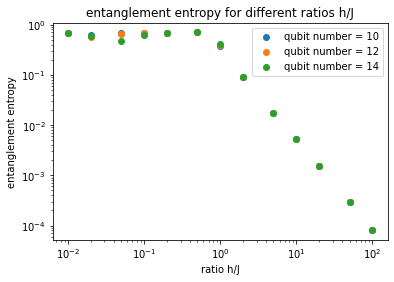

In [6]:
def plot_entanglement_entropy():
    qubit_num = np.array([10, 12, 14])
    ground_state_open_dict = np.load(save_direc_groundstate_open, allow_pickle='TRUE')
    ground_state_open_dict = ground_state_open_dict.item()
    for i in range(0, np.size(qubit_num)):
        entropies = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            ground_state = ground_state_open_dict[str(qubit_num[i]) + ' ' + str(ratios_h_j[j])]
            entropies[j] = BFQuantumState(qubit_num[i], ground_state).entanglement_entropy()
        plt.scatter(ratios_h_j, entropies, label='qubit number = ' + str(qubit_num[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('entanglement entropy for different ratios h/J')
    plt.xlabel('ratio h/J')
    plt.ylabel('entanglement entropy')
    plt.legend()
    plot_save_direc = 'plots\Entanglement_entropy_brute_force\entropies_for qubit numbers ' + str(qubit_num)
    plt.savefig(plot_save_direc)
plot_entanglement_entropy()

For $\frac{h}{J}<1$ the systems ground state is
 $\Psi_0 = \frac{1}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$. Thus, we
 are in a maximally entangled state.
 For $\frac{h}{J}>1$ the ground state converges towards
 the state $\Psi_0 = |++ ... + \rangle$ where $|+ \rangle = \frac{1}{\sqrt{2}}
|0 \rangle + |1 \rangle$ which is not entangled. Hence, we can understand the overall
shape of the curve.

Open question: Why is there a local minimum at $\frac{h}{J} \approx 0.02$ ? Why is it
getting more pronounced for more qubits?

We investigate whether the minimum also shows up for periodic boundary conditions.

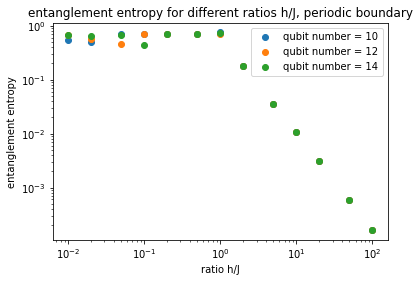

In [7]:
def plot_entanglement_entropy_periodic():
    qubit_num = np.array([10, 12, 14])
    ground_state_periodic_dict = np.load(save_direc_groundstate_periodic, allow_pickle='TRUE')
    ground_state_periodic_dict = ground_state_periodic_dict.item()
    for i in range(0, np.size(qubit_num)):
        entropies = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            ground_state = ground_state_periodic_dict[str(qubit_num[i]) + ' ' + str(ratios_h_j[j])]
            entropies[j] = BFQuantumState(qubit_num[i], ground_state).entanglement_entropy()
        plt.scatter(ratios_h_j, entropies, label='qubit number = ' + str(qubit_num[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.title('entanglement entropy for different ratios h/J, periodic boundary')
    plt.xlabel('ratio h/J')
    plt.ylabel('entanglement entropy')
    plt.legend()
    plot_save_direc = 'plots\Entanglement_entropy_brute_force\entropies_periodic_boundary_for qubit numbers ' + str(qubit_num)
    plt.savefig(plot_save_direc)
plot_entanglement_entropy_periodic()

We obtain a similar shape with the same local minimum.